## Evaluation with human judgements from SimpEval

In [1]:
!pip install evaluate
!pip install sacrebleu
!pip install pandarallel

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from labeling_functions import get_all_lfs
import pandas as pd
import os
import tqdm
from scipy import stats
import pickle

from pandarallel import pandarallel
pandarallel.initialize()
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

from functools import lru_cache

from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

import warnings

/usr/local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


resources get initialised


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [3]:
# Metrics
from evaluate import load
sari = load("sari")

from usb_utils import bertscore
import textstat
fkgl = textstat.flesch_kincaid_grade

# BATS model
from bats_label_model import BatsModel
model = BatsModel("MTurkSF")
bats_score = model.calc_score

# MPIRE
from usb_utils import mpire_score

100%|██████████| 100/100 [00:00<00:00, 270.27epoch/s]
/workspace/pruning_lfs.py:52: RuntimeWarning: invalid value encountered in scalar divide
  merged_data.append([index, polarity, cov_simp, cov_src, precision, 1 - precision, cov_simp+cov_src, abs(cov_simp - cov_src), abs(cov_simp - cov_src)/(cov_simp+cov_src)])
/usr/local/lib/python3.8/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning: divide by zero encountered in divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)


In [4]:
# Datasets
df_simpeval_2022 = pd.read_csv("/workspace/datasets/simpeval/LENS/data/simpeval_2022.csv")
df_simpeval_DA = pd.read_csv("/workspace/datasets/simpeval/LENS/data/simpDA_2022.csv")
df_simpeval_likert = pd.read_csv("/workspace/datasets/simpeval/LENS/data/simplikert_2022.csv")

# preprocessed
from load_simplicity import load_asset_ds
from load_simplicity import load_metaeval_ds
from load_simplicity import load_questeval_ds
from load_simplicity import load_simpeval_ds

asset_simp = load_asset_ds()
metaeval_simp = load_metaeval_ds()
questeval_simp = load_questeval_ds()
simpeval_simp = load_simpeval_ds() # we need this one


In [5]:
df_simpeval = simpeval_simp.loc[simpeval_simp.apply(lambda row: "simpDA_2022" in row["inner_ds"], axis=1)]

In [6]:
df_simpeval

,ds_id,src,simp,simplicityScore,meaningScore,origin,inner_ds
0,SimpEval_22,"On the fifth day of flight, November 20, 2022,...","On November 20, 2022, the Orion spacecraft sta...",93.555556,92.833333,GPT-3-few-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]"
1,SimpEval_22,The last president to run after leaving office...,The last president who ran after leaving the p...,86.888889,77.500000,Human 1 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]"
2,SimpEval_22,The complainant claimed that he had not renoun...,The complaint said he did not renounce his Nep...,87.777778,56.000000,Human 2 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]"
3,SimpEval_22,The club said on social media that customers s...,The club announced on social media that custom...,70.111111,85.500000,GPT-3-zero-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]"
4,SimpEval_22,Bone has published numerous books including Fa...,Bone has published many books including Fantas...,77.500000,85.166667,Muss,"[simpDA_2022, simplikert_2022]"
...,...,...,...,...,...,...,...
355,SimpEval_22,A Morning Consult poll in mid-November 2022 fo...,A Morning Consult poll in mid-November 2022 fo...,57.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"
356,SimpEval_22,Robinson returned to West Point in 1972 to ser...,Robinson returned to West Point in 1972 to be ...,60.222222,98.833333,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"
357,SimpEval_22,"In the interior, on the facade and the portico...","In the interior, on the facade and the portico...",62.888889,94.666667,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"
358,SimpEval_22,The Creative Gene is an autobiographical book ...,The Creative Gene is an autobiographical book ...,45.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]"


In [7]:
df_simpeval_DA_dict = {}
for id in df_simpeval_DA["Input.id"].unique():
    df_simpeval_DA_dict[id] = {
    "Input.original": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id].iloc[0]["Input.original"],
    "Input.simplified": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id].iloc[0]["Input.simplified"],
    "Input.system": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id].iloc[0]["Input.system"],
    "Answer.adequacy": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id]["Answer.adequacy"].mean(),
    "Answer.fluency": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id]["Answer.fluency"].mean(),
    "Answer.simplicity": df_simpeval_DA.loc[df_simpeval_DA["Input.id"] == id]["Answer.simplicity"].mean()
    }
df_simpeval_DA_mean = pd.DataFrame(df_simpeval_DA_dict).T

df_simpeval_likert_dict = {}
for id in df_simpeval_likert["Input.id"].unique():
    df_simpeval_likert_dict[id] = {
    "Input.original": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id].iloc[0]["Input.original"],
    "Input.simplified": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id].iloc[0]["Input.simplified"],
    "Input.system": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id].iloc[0]["Input.system"],
    "Answer.adequacy": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id]["Answer.adequacy"].mean(),
    "Answer.fluency": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id]["Answer.fluency"].mean(),
    "Answer.simplicity": df_simpeval_likert.loc[df_simpeval_likert["Input.id"] == id]["Answer.simplicity"].mean()
    }
df_simpeval_likert_mean = pd.DataFrame(df_simpeval_likert_dict).T

In [8]:
df_simpeval = pd.read_pickle("df_simpeval_eval.pkl")

In [9]:
# BertScore

#df_simpeval["BERTscore"] = df_simpeval.progress_apply(lambda row: bertscore(row["src"], row["simp"]) , axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# Sari
#df_simpeval["sari"] = df_simpeval.progress_apply(lambda row:  sari.compute(sources=[row["src"]], predictions=[row["simp"]], references=[[]])["sari"] , axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# BATS score
#df_simpeval["test_MTurkSF_orig"] = df_simpeval.progress_apply(lambda row: bats_score(row["simp"]) , axis = 1)
#df_simpeval.to_pickle("df_simpeval_eval.pkl")

# FKGL
df_simpeval["FKGL"] = df_simpeval.progress_apply(lambda row: fkgl(row["simp"]) , axis = 1)
df_simpeval.to_pickle("df_simpeval_eval.pkl")


100%|██████████| 360/360 [00:00<00:00, 5457.39it/s]


In [18]:
pearson_r = {"simpeval_DA": 
{"BERTscore":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["BERTscore"].to_list()), 
"sari":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["sari"].to_list()), 
#"BATSscore":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["test_MTurkSF_orig"].to_list()), 
"fkgl":stats.pearsonr(df_simpeval["simplicityScore"].to_list(), df_simpeval["FKGL"].to_list())}
}

spearman_r = {"simpeval_DA": 
{"BERTscore":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["BERTscore"].to_list()), 
"sari":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["sari"].to_list()), 
#"BATSscore":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["test_MTurkSF_orig"].to_list()), 
"fkgl":stats.spearmanr(df_simpeval["simplicityScore"].to_list(), df_simpeval["FKGL"].to_list())}
}

In [13]:
df_simpeval

,ds_id,src,simp,simplicityScore,meaningScore,origin,inner_ds,BERTscore,sari,FKGL
0,SimpEval_22,"On the fifth day of flight, November 20, 2022,...","On November 20, 2022, the Orion spacecraft sta...",93.555556,92.833333,GPT-3-few-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.586026,66.666667,6.4
1,SimpEval_22,The last president to run after leaving office...,The last president who ran after leaving the p...,86.888889,77.500000,Human 1 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.645294,66.666667,9.9
2,SimpEval_22,The complainant claimed that he had not renoun...,The complaint said he did not renounce his Nep...,87.777778,56.000000,Human 2 Writing,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.614902,66.666667,10.3
3,SimpEval_22,The club said on social media that customers s...,The club announced on social media that custom...,70.111111,85.500000,GPT-3-zero-shot,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.726086,66.666667,10.5
4,SimpEval_22,Bone has published numerous books including Fa...,Bone has published many books including Fantas...,77.500000,85.166667,Muss,"[simpDA_2022, simplikert_2022]",0.800024,66.666667,9.5
...,...,...,...,...,...,...,...,...,...,...
355,SimpEval_22,A Morning Consult poll in mid-November 2022 fo...,A Morning Consult poll in mid-November 2022 fo...,57.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.900024,75.000000,16.6
356,SimpEval_22,Robinson returned to West Point in 1972 to ser...,Robinson returned to West Point in 1972 to be ...,60.222222,98.833333,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.907937,66.666667,7.6
357,SimpEval_22,"In the interior, on the facade and the portico...","In the interior, on the facade and the portico...",62.888889,94.666667,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.890400,66.666667,11.3
358,SimpEval_22,The Creative Gene is an autobiographical book ...,The Creative Gene is an autobiographical book ...,45.666667,100.000000,T5-3B,"[simpDA_2022, simplikert_2022, simpeval_2022]",0.970796,66.666667,20.5


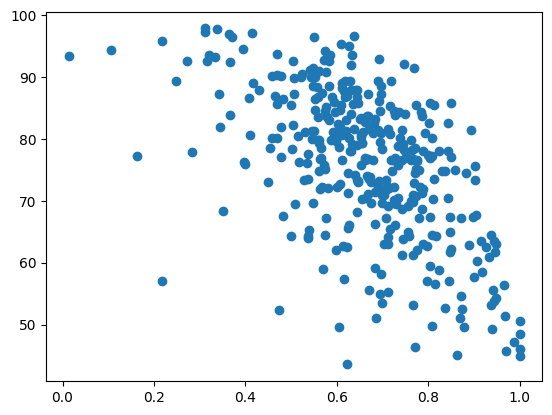

In [15]:
x = np.array(df_simpeval["BERTscore"].to_list())
y = np.array(df_simpeval["simplicityScore"].to_list())

plt.scatter(x, y)
plt.show()

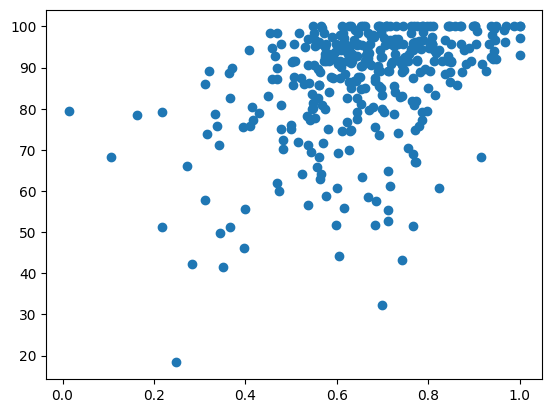

In [17]:
x = np.array(df_simpeval["BERTscore"].to_list())
y = np.array(df_simpeval["meaningScore"].to_list())

plt.scatter(x, y)
plt.show()

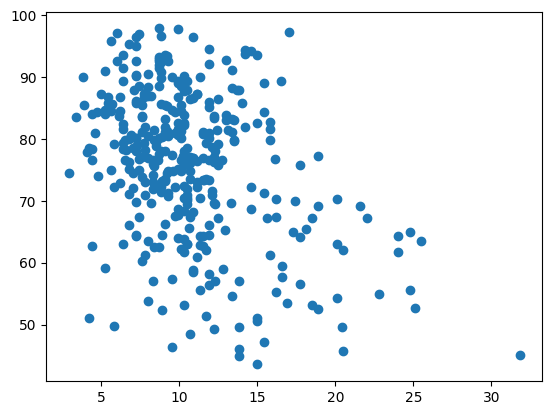

In [16]:
x = np.array(df_simpeval["FKGL"].to_list())
y = np.array(df_simpeval["simplicityScore"].to_list())

plt.scatter(x, y)
plt.show()

In [11]:
pearson_r

{'simpeval_DA': {'BERTscore': PearsonRResult(statistic=-0.5714942551937424, pvalue=1.3349390777818822e-32),
  'sari': PearsonRResult(statistic=-0.2623660814414458, pvalue=4.4305464512684615e-07),
  'fkgl': PearsonRResult(statistic=-0.3900788382401816, pvalue=1.5671577258372067e-14)}}

In [19]:
spearman_r

{'simpeval_DA': {'BERTscore': SignificanceResult(statistic=-0.5551451744922765, pvalue=1.7206631387694662e-30),
  'sari': SignificanceResult(statistic=-0.17527113383053647, pvalue=0.0008382055436318228),
  'fkgl': SignificanceResult(statistic=-0.322158175500493, pvalue=3.8768147375506035e-10)}}

In [ ]:
x = np.array(df_simpeval_2022["human_mean"].to_list())
y = np.array(df_simpeval_2022["sari"].to_list())

res = stats.kendalltau(x, y)
res.statistic

## Checking weights for LF Clusters

In [ ]:
from pruning_lfs import prune_lfs as pruner

In [ ]:
lfs = pruner()

/workspace/pruning_lfs.py:52: RuntimeWarning: invalid value encountered in scalar divide
  merged_data.append([index, polarity, cov_simp, cov_src, precision, 1 - precision, cov_simp+cov_src, abs(cov_simp - cov_src), abs(cov_simp - cov_src)/(cov_simp+cov_src)])


In [ ]:
len(lfs)

328

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
cluster_manual = pickle.load(open("/workspace/datasets/clustering_manual_LFs.pkl", "rb"))
cluster_automatic = pickle.load(open("/workspace/datasets/auto_cluster_dic.pkl", "rb"))

auto = []
manual = []

for k in cluster_manual.keys():
    auto.append(cluster_automatic[k])
    manual.append(cluster_manual[k])
    print(k,auto[-1], manual[-1])

adjusted_rand_score(manual, auto)

lf_words_cnt_wcount=15_SIMPLE 0 0
lf_words_cnt_wcount=16_SIMPLE 0 0
lf_words_cnt_wcount=17_SIMPLE 0 0
lf_words_cnt_wcount=18_SIMPLE 0 0
lf_words_cnt_wcount=19_SIMPLE 2 0
lf_words_cnt_wcount=20_SIMPLE 2 0
lf_words_cnt_wcount=21_SIMPLE 2 0
lf_words_cnt_wcount=22_SIMPLE 2 0
lf_words_cnt_wcount=23_SIMPLE 2 0
lf_words_cnt_wcount=24_SIMPLE 2 0
lf_words_cnt_wcount=20_NOT_SIMPLE 1 0
lf_words_cnt_wcount=21_NOT_SIMPLE 1 0
lf_words_cnt_wcount=22_NOT_SIMPLE 1 0
lf_words_cnt_wcount=23_NOT_SIMPLE 1 0
lf_words_cnt_wcount=24_NOT_SIMPLE 1 0
lf_words_cnt_wcount=25_NOT_SIMPLE 1 0
lf_words_cnt_wcount=26_NOT_SIMPLE 1 0
lf_words_cnt_wcount=27_NOT_SIMPLE 1 0
lf_words_cnt_wcount=28_NOT_SIMPLE 1 0
lf_words_cnt_wcount=29_NOT_SIMPLE 0 0
lf_words_cnt_wcount=30_NOT_SIMPLE 0 0
lf_words_cnt_wcount=31_NOT_SIMPLE 0 0
lf_words_cnt_wcount=32_NOT_SIMPLE 0 0
lf_words_cnt_wcount=33_NOT_SIMPLE 0 0
lf_words_cnt_wcount=34_NOT_SIMPLE 0 0
lf_words_cnt_wcount=35_NOT_SIMPLE 0 0
lf_words_cnt_wcount=36_NOT_SIMPLE 0 0
lf_words_cnt_w

0.07048466331344759

In [ ]:
lf_names = [a.name for a in prune_lfs()]

NameError: name 'prune_lfs' is not defined

In [ ]:
model_lf_weights = {}
for i, weight in enumerate(model.label_model.get_weights()):
    model_lf_weights[lf_names[i]] = weight

/usr/local/lib/python3.8/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning: divide by zero encountered in divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)


In [ ]:
model.label_model.score

TypeError: score() missing 2 required positional arguments: 'L' and 'Y'

In [ ]:
model_lf_weights.values()

dict_values([0.9619468950526788, 0.9482166937299685, 0.9529086735518274, 0.9455221558078032, 0.9366248312982465, 0.9310878349063659, 0.9071245058144753, 0.9038895113266396, 0.8853151508392841, 0.840304193368001, 0.7668042545626503, 0.8577059641719714, 0.9044466808328667, 0.9332492060958133, 0.9849847811267727, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3603624881943688, 1.0, 1.0, 1.0, 1.0, 0.9917048030300066, 1.0, 0.5908339153858833, 1.0, 1.0, 1.0, 0.6248972205284535, 1.0, 1.0, 1.0, 1.0, 0.9539656884766494, 0.9170133598745451, 1.0, 1.0, 1.0, 0.9345297764626925, 0.9536078108552223, 0.9466952408230017, 0.9461321834950586, 0.782179660134716, 0.7408020378139173, 0.45792042749235407, 0.4861153755148394, 0.5126350680609485, 0.6515763225336797, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9929606605292064, 1.0, 0.9452091460577018, 0.7185830846683112, 0.46821456037979886, 0.557501698415917, 0.4430950541398488, 0.3709285137893156, 0.5336140704884504, 0.6

In [ ]:
cluster_manual = pickle.load(open("/workspace/datasets/clustering_manual_LFs_with_CLUSTERS.pkl", "rb"))

cluster_weights = {}
for v in set(cluster_manual.values()):
    cluster_weights[v] = []

for k in cluster_manual.keys():
    cluster_weights[cluster_manual[k]].append(model_lf_weights[k])

In [ ]:
for k in cluster_weights.keys():
    print(k, np.sum(cluster_weights[k]))

Pragmatic 2.8890252453093925
Structural 122.37321378481032
Syntactic 37.22355829608548
Lexical 108.92948228127669


In [ ]:
len(model_lf_weights.values())

328